In [1]:
!curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id=11wp4Bm-hEVwmZq8GmqbLpKpJiqvDSNAe" > /dev/null
!curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm=$(awk '/download/ {print $NF}' ./cookie)&id=11wp4Bm-hEVwmZq8GmqbLpKpJiqvDSNAe" -o data.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100  2423  100  2423    0     0   1483      0  0:00:01  0:00:01 --:--:--  1483


In [2]:
!pip install gdown
!gdown https://drive.google.com/uc?id=11wp4Bm-hEVwmZq8GmqbLpKpJiqvDSNAe -O data.zip

Downloading...
From (original): https://drive.google.com/uc?id=11wp4Bm-hEVwmZq8GmqbLpKpJiqvDSNAe
From (redirected): https://drive.google.com/uc?id=11wp4Bm-hEVwmZq8GmqbLpKpJiqvDSNAe&confirm=t&uuid=01804b68-d27f-41d4-8120-2dfe972828ba
To: /content/data.zip
100% 154M/154M [00:04<00:00, 34.0MB/s]


In [3]:
!unzip data.zip -d /content/people_photos/


Archive:  data.zip
replace /content/people_photos/dataset/masks/1803262049-00000501.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [16]:
import cv2

img = cv2.imread("/content/people_photos/dataset/images/1803260054-00000353.jpg", cv2.IMREAD_UNCHANGED)
mask = cv2.imread("/content/people_photos/dataset/masks/1803260054-00000353.png", cv2.IMREAD_UNCHANGED)[..., -1]

In [4]:
import matplotlib.pyplot as plt

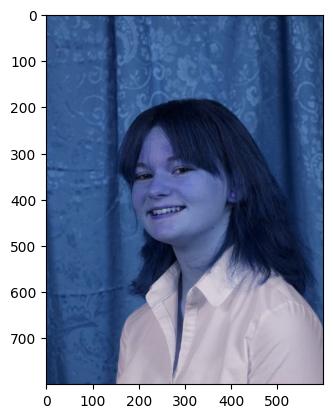

In [6]:
plt.imshow(img)

In [6]:
from glob import glob
# imgs_list - это список путей к изображениям
imgs_list = glob("/content/people_photos/dataset/images/**/*.jpg", recursive=True)

In [7]:
from torch.utils.data import Dataset
import numpy as np
import torch
import cv2
from torchvision import transforms

class SelfieDataset(Dataset):
    def __init__(self, imgs_list, transform=None, mask_transform=None):
        self.imgs = imgs_list
        self.transform = transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Построение пути к маске
        mask_path = img_path.replace("/images/", "/masks/").replace(".jpg", ".png")
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

        # Добавление паддинга
        top = int((800 - 600) / 2)
        bottom = 800 - 600 - top
        img_padded = cv2.copyMakeBorder(img, top, bottom, 0, 0, cv2.BORDER_CONSTANT, value=[0, 0, 0])
        mask_padded = cv2.copyMakeBorder(mask, top, bottom, 0, 0, cv2.BORDER_CONSTANT, value=[0, 0, 0])

        # Преобразование PyTorch (включая изменение размера)
        if self.transform:
            img_padded = self.transform(img_padded)
        else:
            # Преобразование по умолчанию, если transform не задан
            transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((256, 256)),
                transforms.ToTensor(),
            ])
            img_padded = transform(img_padded)

        if self.mask_transform:
            mask_padded = self.mask_transform(mask_padded)
        else:
            # Преобразование по умолчанию, если mask_transform не задан
            mask_transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST),
                transforms.ToTensor(),
            ])
            mask_padded = mask_transform(mask_padded)

        # Бинаризация маски
        mask_padded = (mask_padded > 0.5).float()

        return {"image": img_padded, "mask": mask_padded}

## train/test split

In [8]:
from sklearn.model_selection import train_test_split

train_imgs, test_imgs = train_test_split(imgs_list, test_size=0.2, random_state=42)

In [9]:
train_dataset = SelfieDataset(train_imgs)
test_dataset = SelfieDataset(test_imgs)

## U-Net

In [10]:
import torch.nn as nn
import torch.nn.functional as F

In [11]:
# Фиксация сидов
import random

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(42)

In [12]:
# Метрика Jaccard Index (IoU)

def jaccard_index(pred, target):
    # Преобразование тензоров к булевому типу для выполнения логических операций
    pred = pred.bool()
    target = target.bool()

    intersection = (pred & target).sum((1, 2))  # Пересечение
    union = (pred | target).sum((1, 2))  # Объединение

    iou = (intersection + 1e-6) / (union + 1e-6)  # Вычисление IoU с добавлением малого числа для избежания деления на ноль
    return iou.mean()  # Возвращение среднего значения IoU по батчу

In [13]:
# Предположим, train_imgs содержит пути к обучающим изображениям
train_imgs, val_imgs = train_test_split(train_imgs, test_size=0.2, random_state=42)

In [27]:
import os

# Путь к папке, где вы хотите сохранить файлы
folder_path = '/content/drive/My Drive/YourFolderName'

# Создание папки, если она не существует
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

In [16]:
import pickle

# Сохранение списков путей к изображениям
with open('/content/drive/My Drive/train_imgs.pkl', 'wb') as f:
    pickle.dump(train_imgs, f)

with open('/content/drive/My Drive/val_imgs.pkl', 'wb') as f:
    pickle.dump(val_imgs, f)

with open('/content/drive/My Drive/test_imgs.pkl', 'wb') as f:
    pickle.dump(test_imgs, f)


In [ ]:
import pickle
with open('/content/drive/My Drive/train_imgs.pkl', 'rb') as f:
    train_imgs = pickle.load(f)

with open('/content/drive/My Drive/val_imgs.pkl', 'rb') as f:
    val_imgs = pickle.load(f)

with open('/content/drive/My Drive/test_imgs.pkl', 'rb') as f:
    test_imgs = pickle.load(f)

In [27]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, padding=1):  # Добавлен параметр padding с значением по умолчанию
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=padding, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=padding, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out



In [28]:
class ChannelAttentionModule(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttentionModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction_ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction_ratio, in_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


In [25]:
# Интеграция в CNNBlock
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, padding=1):  # Добавлен параметр padding
        super(CNNBlock, self).__init__()
        self.resblock = ResidualBlock(in_channels, out_channels, padding=padding)  # Передача padding в ResidualBlock
        self.attention = ChannelAttentionModule(out_channels)

    def forward(self, x):
        x = self.resblock(x)
        x = self.attention(x)
        return x


In [23]:
class CNNBlocks(nn.Module):
    def __init__(self, n_conv, in_channels, out_channels, padding):
          super(CNNBlocks, self).__init__()

          self.layers = nn.ModuleList()
          for i in range(n_conv):
              self.layers.append(CNNBlock(in_channels, out_channels, padding=padding))
              in_channels = out_channels

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels, padding, n_down=4):
        super(Encoder, self).__init__()

        self.enc_layers = nn.ModuleList()
        for _ in range(n_down):
            self.enc_layers += [CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding),
                                nn.MaxPool2d(2, 2)]

            in_channels = out_channels
            out_channels = 2 * out_channels

        self.enc_layers.append(CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding))

    def forward(self, x):
        connections = []
        for layer in self.enc_layers:
            if isinstance(layer, CNNBlocks):
                x = layer(x)
                connections.append(x)
            else:
                x = layer(x)
        return x, connections

class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels, exit_channels, padding, n_up=4):
        super(Decoder, self).__init__()

        self.exit_channels = exit_channels
        self.layers = nn.ModuleList()

        for i in range(n_up):
            self.layers += [nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
                            CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding)]

            in_channels //= 2
            out_channels //= 2

        self.layers.append(nn.Conv2d(in_channels, self.exit_channels, kernel_size=1, padding=0))

    def forward(self, x, connections):
        connections.pop(-1)
        for layer in self.layers:
            if isinstance(layer, CNNBlocks):
                connections_current = connections.pop(-1)
                x = torch.cat([x, connections_current], dim=1)
                x = layer(x)
            else:
                x = layer(x)
        return x



class UNET(nn.Module):
    def __init__(self, in_channels, first_out_channels, exit_channels, n_down=4, padding=1):
        super(UNET, self).__init__()
        self.encoder = Encoder(in_channels, first_out_channels, padding=padding, n_down=n_down)
        self.decoder = Decoder(first_out_channels * (2 ** n_down), # downscaled (so increase n maps 2x n_down times)
                               first_out_channels * (2 ** (n_down - 1)), # we have 2x channels here, because need to concat
                               exit_channels, padding=padding, n_up=n_down)

    def forward(self, x):
        enc_out, connections = self.encoder(x)
        return self.decoder(enc_out, connections)


In [32]:
from torch.utils.data import DataLoader

train_dataset = SelfieDataset(train_imgs)
val_dataset = SelfieDataset(val_imgs)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## KFold

In [33]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)


Увеличим batch size до 64 и установим learning rate = 0.01 для ускорения обучения в виду ограниченности ресурсов

In [34]:
fold_results = []
models = []

for fold, (train_idx, val_idx) in enumerate(kf.split(train_imgs)):
    print(f'Fold {fold+1}')
    # Создание наборов данных для текущего фолда
    train_fold_imgs = [train_imgs[i] for i in train_idx]
    val_fold_imgs = [train_imgs[i] for i in val_idx]

    train_fold_dataset = SelfieDataset(train_fold_imgs)
    val_fold_dataset = SelfieDataset(val_fold_imgs)

    train_loader = DataLoader(train_fold_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_fold_dataset, batch_size=64)

    # Создание и обучение модели для текущего фолда


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Инициализация модели, функции потерь и оптимизатора
    model = UNET(3, 16, 1).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    # Для сохранения истории обучения
    train_losses, val_losses, train_ious, val_ious = [], [], [], []

    num_epochs = 25  # Примерное количество эпох


    # early stop
    best_val_loss = float('inf')
    epochs_no_improve = 0
    n_epochs_stop = 5  # Количество эпох без улучшений после которых обучение будет прервано
    early_stop = False


    for epoch in range(num_epochs):
        model.train()
        train_loss, train_iou = 0, 0
        for batch in train_loader:
            images, masks = batch['image'].to(device), batch['mask'].to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_iou += jaccard_index((torch.sigmoid(outputs) > 0.5).float(), masks)

        train_losses.append(train_loss / len(train_loader))
        train_ious.append(train_iou / len(train_loader))

        # Валидация
        model.eval()
        val_loss, val_iou = 0, 0
        with torch.no_grad():
            for batch in val_loader:
                images, masks = batch['image'].to(device), batch['mask'].to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)

                val_loss += loss.item()
                val_iou += jaccard_index((torch.sigmoid(outputs) > 0.5).float(), masks)

        val_losses.append(val_loss / len(val_loader))
        val_ious.append(val_iou / len(val_loader))

        # Проверка на необходимость ранней остановки
        if val_loss < best_val_loss:
            torch.save(model.state_dict(), 'best_model.pth')
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == n_epochs_stop:
                print(f'\nEarly stopping after {epoch+1} epochs!')
                early_stop = True
                break

        print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Train IoU: {train_ious[-1]}, Val IoU: {val_ious[-1]}')


    fold_result = {
      "train_loss": train_losses,
      "val_loss": val_losses,
      "train_iou": train_ious,
      "val_iou": val_ious,
      "best_val_loss": best_val_loss,
      }
    fold_results.append(fold_result)


    models.append(model)


Fold 1
Epoch 1, Train Loss: 0.5680089704692364, Val Loss: 4.351292014122009, Train IoU: 0.41833990812301636, Val IoU: 0.11319593340158463
Epoch 2, Train Loss: 0.35179288499057293, Val Loss: 6.173107385635376, Train IoU: 0.6553657650947571, Val IoU: 0.48261719942092896
Epoch 3, Train Loss: 0.2278614677488804, Val Loss: 1.3752481341362, Train IoU: 0.7441368699073792, Val IoU: 0.5981972217559814
Epoch 4, Train Loss: 0.1992135038599372, Val Loss: 0.42157066613435745, Train IoU: 0.7632939219474792, Val IoU: 0.7367509603500366
Epoch 5, Train Loss: 0.17775996774435043, Val Loss: 0.2520361728966236, Train IoU: 0.7788982391357422, Val IoU: 0.7625728249549866
Epoch 6, Train Loss: 0.1673318287357688, Val Loss: 0.21272851899266243, Train IoU: 0.7907597422599792, Val IoU: 0.7202187180519104
Epoch 7, Train Loss: 0.1588180297985673, Val Loss: 0.16604305431246758, Train IoU: 0.799383282661438, Val IoU: 0.7962153553962708
Epoch 8, Train Loss: 0.14512220211327076, Val Loss: 0.16373410820960999, Train Io

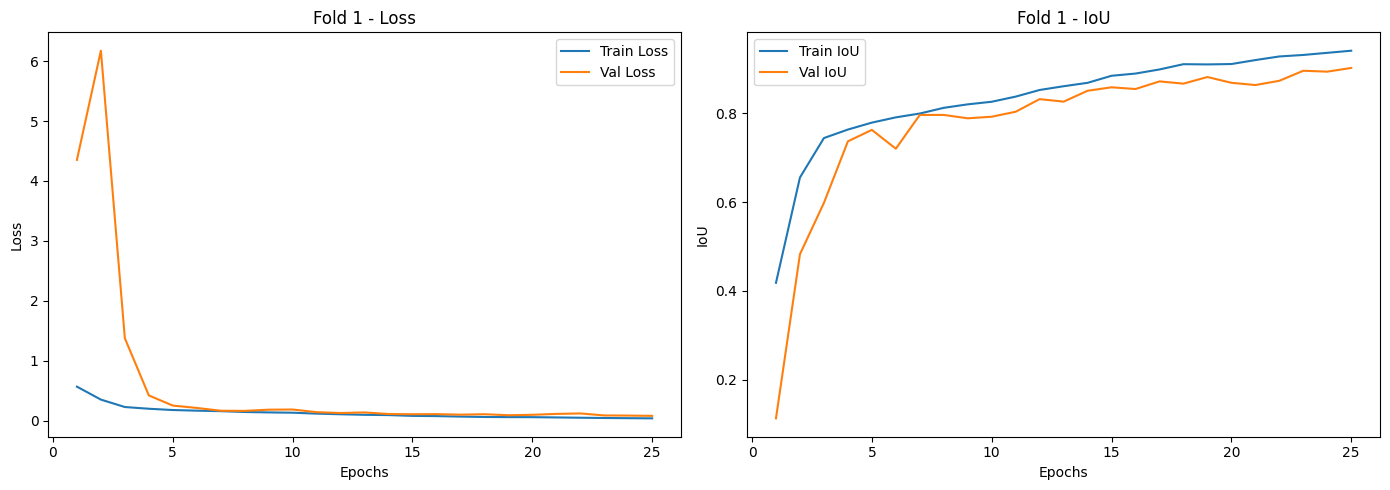

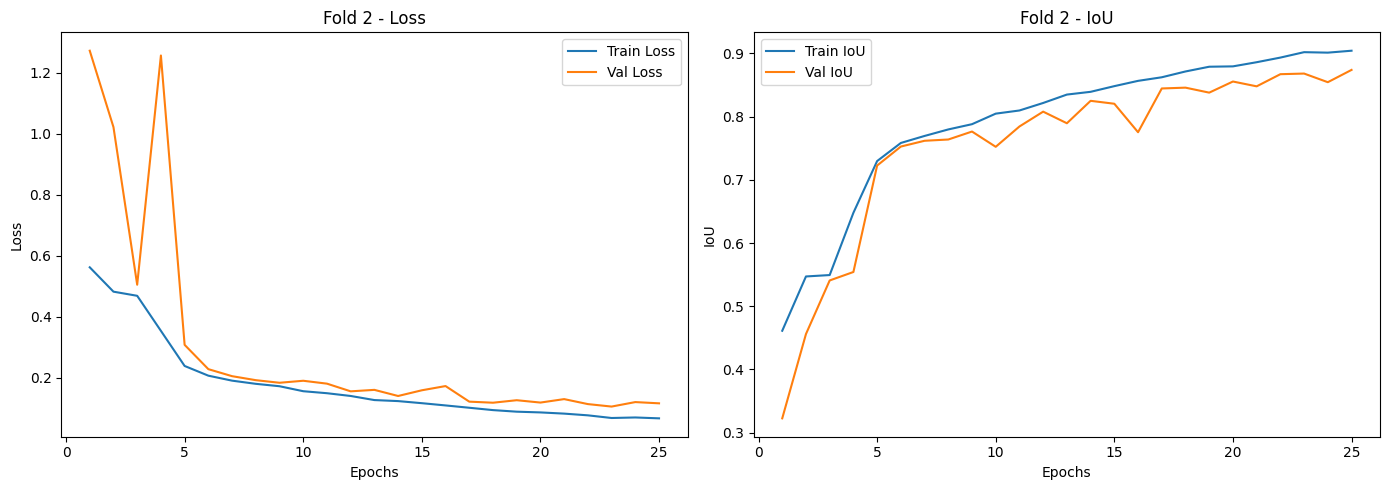

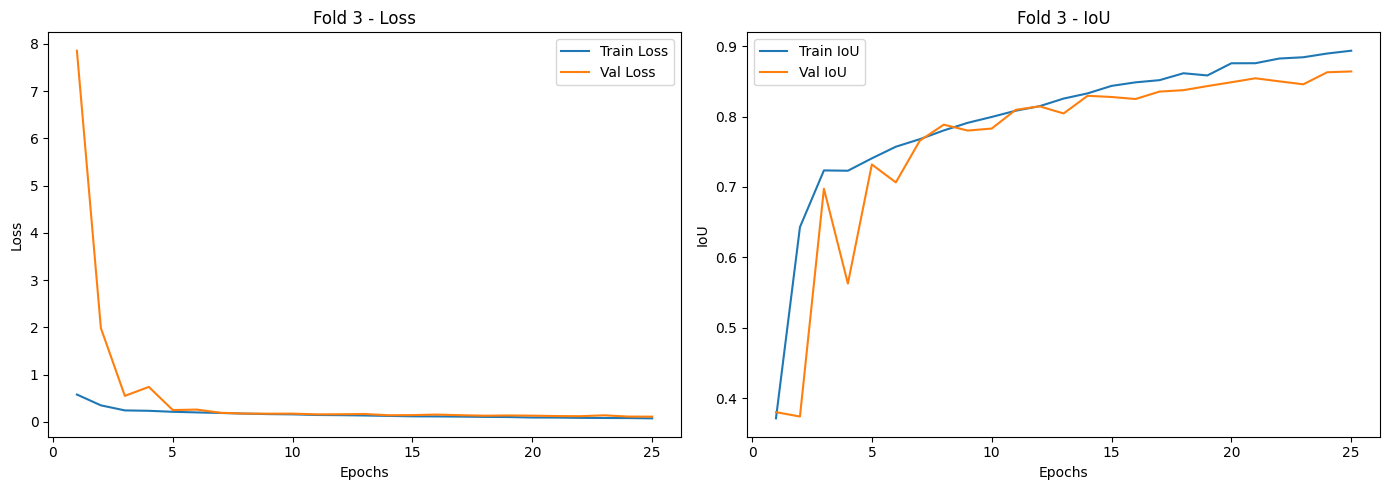

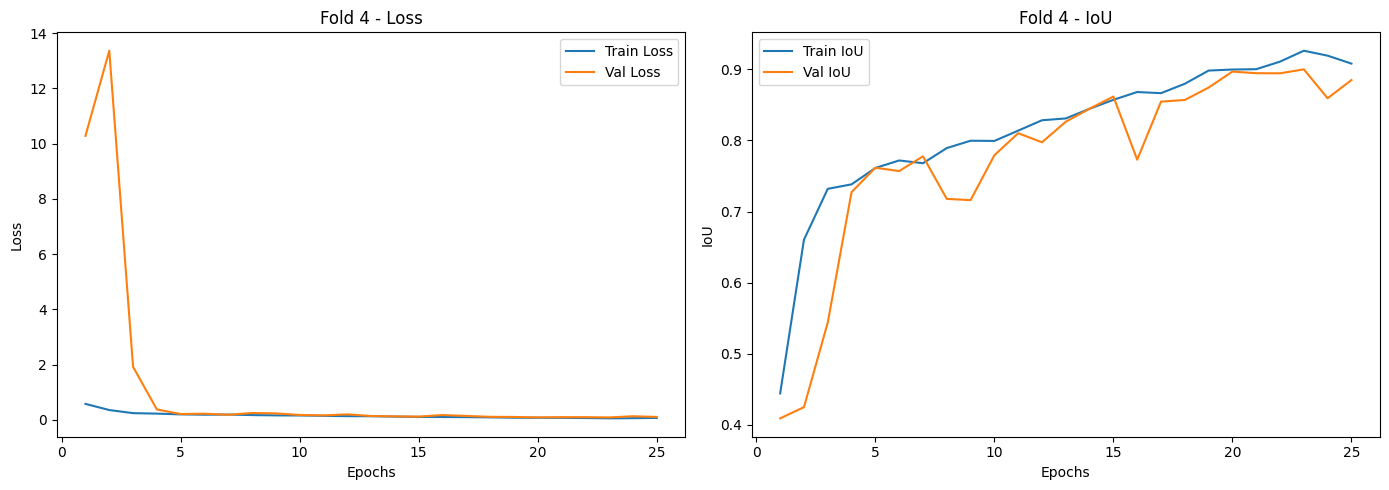

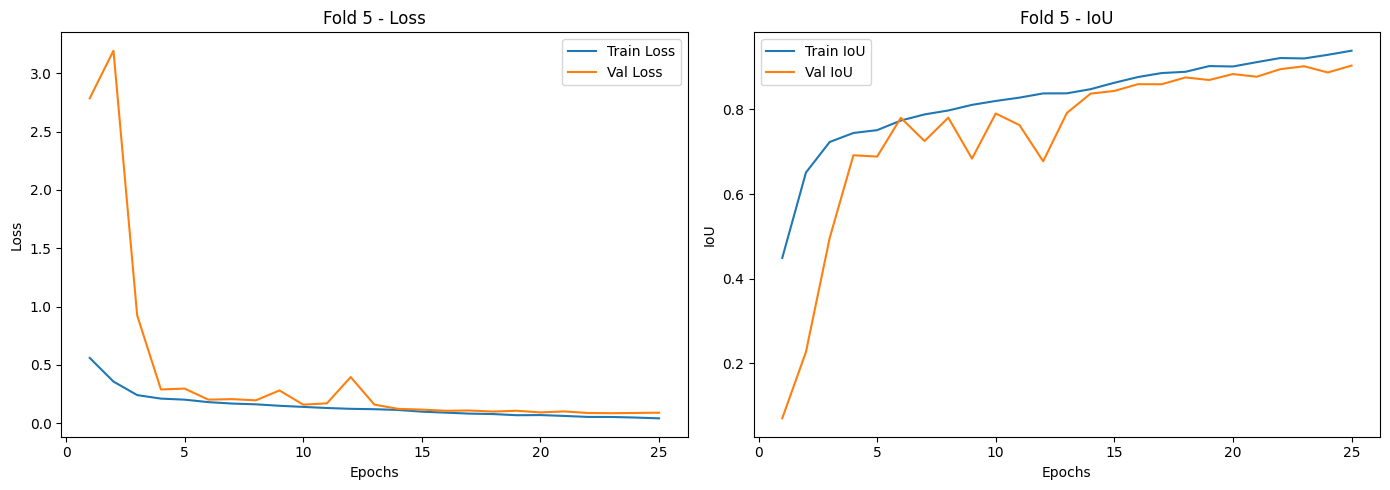

In [46]:
import matplotlib.pyplot as plt

# Предполагается, что fold_results - это список словарей с результатами для каждого фолда
for i, fold_result in enumerate(fold_results):
    epochs_range = range(1, len(fold_result["train_loss"]) + 1)

    plt.figure(figsize=(14, 5))

    # График потерь
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, fold_result["train_loss"], label='Train Loss')
    plt.plot(epochs_range, fold_result["val_loss"], label='Val Loss')
    plt.title(f'Fold {i+1} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # График IoU
    train_ious = [ious.item() for ious in fold_result["train_iou"]]
    val_ious = [ious.item() for ious in fold_result["val_iou"]]

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_ious, label='Train IoU')
    plt.plot(epochs_range, val_ious, label='Val IoU')
    plt.title(f'Fold {i+1} - IoU')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.legend()

    plt.tight_layout()
    plt.show()


### запись и чтение обученых моделей и их метрик для работы в случае переполнения памяти

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
models_dir = "/content/drive/My Drive/saved_models"  # Путь к директории на Google Drive

os.makedirs(models_dir, exist_ok=True)

In [43]:
models_dir = "saved_models"

os.makedirs(models_dir, exist_ok=True)

# Сохранение каждой модели в отдельный файл
for i, model in enumerate(models):
    model_filename = f"model_fold_{i+1}.pth"
    model_path = os.path.join(models_dir, model_filename)
    torch.save(model.state_dict(), model_path)
    print(f"Model from fold {i+1} saved to {model_path}")

# Вывод сообщения об успешном сохранении
print(f"All {len(models)} models have been saved successfully.")
import pickle

# Сохранение результатов обучения для каждого фолда
results_filename = "fold_results.pkl"
results_path = os.path.join(models_dir, results_filename)
with open(results_path, 'wb') as handle:
    pickle.dump(fold_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

Model from fold 1 saved to saved_models/model_fold_1.pth
Model from fold 2 saved to saved_models/model_fold_2.pth
Model from fold 3 saved to saved_models/model_fold_3.pth
Model from fold 4 saved to saved_models/model_fold_4.pth
Model from fold 5 saved to saved_models/model_fold_5.pth
All 5 models have been saved successfully.


In [44]:
import pickle

results_filename = "fold_results.pkl"
results_path = os.path.join(models_dir, results_filename)
with open(results_path, 'rb') as handle:
    fold_results = pickle.load(handle)


In [ ]:
import pickle

results_filename = "fold_results.pkl"
results_path = os.path.join(models_dir, results_filename)

with open(results_path, 'rb') as handle:
    fold_results = pickle.load(handle)

print("Training results loaded successfully.")


In [15]:

models_dir = "saved_models"

os.makedirs(models_dir, exist_ok=True)

# Сохранение каждой модели в отдельный файл
for i, model in enumerate(models):
    model_filename = f"model_fold_{i+1}.pth"
    model_path = os.path.join(models_dir, model_filename)
    torch.save(model.state_dict(), model_path)
    print(f"Model from fold {i+1} saved to {model_path}")

print(f"All {len(models)} models have been saved successfully.")


All 0 models have been saved successfully.


In [14]:
import torch
import os

models = []
models_dir = "saved_models"  # Папка, где сохранены модели

# Убедитесь, что класс модели UNET уже определен
for i in range(len(models)):  # Замените len(models) на фактическое количество моделей, если оно известно
    model_filename = f"model_fold_{i+1}.pth"
    model_path = os.path.join(models_dir, model_filename)
    model = UNET(3, 16, 1)  # Создание модели с той же архитектурой, что и при сохранении
    model.load_state_dict(torch.load(model_path))
    models.append(model)
    print(f"Model from fold {i+1} loaded.")


In [40]:
import pickle

# Сохранение результатов обучения для каждого фолда
results_filename = "fold_results.pkl"
results_path = os.path.join(models_dir, results_filename)
with open(results_path, 'wb') as handle:
    pickle.dump(fold_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [29]:
import torch
# from your_model_definition_file import UNET  # Импортируйте ваш класс модели

models = []
for i in range(5):  # Предполагается, что у вас 5 моделей
    model_path = f"{models_dir}/model_fold_{i+1}.pth"  # Формируем путь к файлу модели
    model = UNET(3, 16, 1)  # Создаём модель с идентичной архитектурой
    model.load_state_dict(torch.load(model_path))
    model.eval()  # Переводим модель в режим оценки
    models.append(model)
    print(f"Model from fold {i+1} loaded.")


Model from fold 1 loaded.
Model from fold 2 loaded.
Model from fold 3 loaded.
Model from fold 4 loaded.
Model from fold 5 loaded.


In [ ]:
print(models)

In [32]:
import pickle

results_filename = "fold_results.pkl"
results_path = os.path.join(models_dir, results_filename)
with open(results_path, 'rb') as handle:
    fold_results = pickle.load(handle)



##  Предсказание на тестовом наборе и агрегация результатов

In [ ]:
# test_dataset = SelfieDataset(test_imgs, transform=YourTransform(), mask_transform=YourMaskTransform())
from torch.utils.data import DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_dataset = SelfieDataset(test_imgs)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Перемещение моделей на GPU
models = [model.to(device) for model in models]



In [35]:
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False) # Уменьшение размера батча

all_preds = []
all_masks = []

with torch.no_grad():
    for batch in test_loader:
        images, masks = batch['image'].to(device), batch['mask'].to(device)
        batch_preds = torch.zeros_like(masks, device=device)

        # Поочередное выполнение предсказаний для каждой модели
        for model in models:
            model.to(device).eval() # Перемещение модели на GPU
            preds = model(images).sigmoid()
            batch_preds += preds / len(models) # Усреднение предсказаний
            model.to('cpu')  # Перемещение модели обратно на CPU
            torch.cuda.empty_cache() # Освобождение памяти GPU

        all_preds.append(batch_preds)
        all_masks.append(masks)

# Конвертация списков в тензоры
all_preds = torch.cat(all_preds, dim=0)
all_masks = torch.cat(all_masks, dim=0)


In [40]:

# Вычисление метрик на агрегированных предсказаниях
test_iou = jaccard_index((all_preds > 0.5).float(), all_masks).item()

print(f'Test IoU: {test_iou}')

Test IoU: 0.9069158434867859


Снижение IoU с 0.9329 до 0.9069 при использовании ансамбля моделей вместо одиночной U-Net обусловленно внесёнными изменениями для ускорения вычислений. Но по прежнему результат сегментации достаточно хороший.

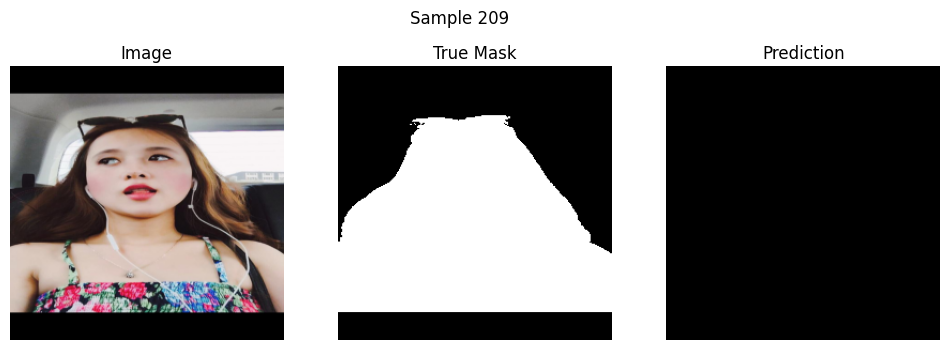

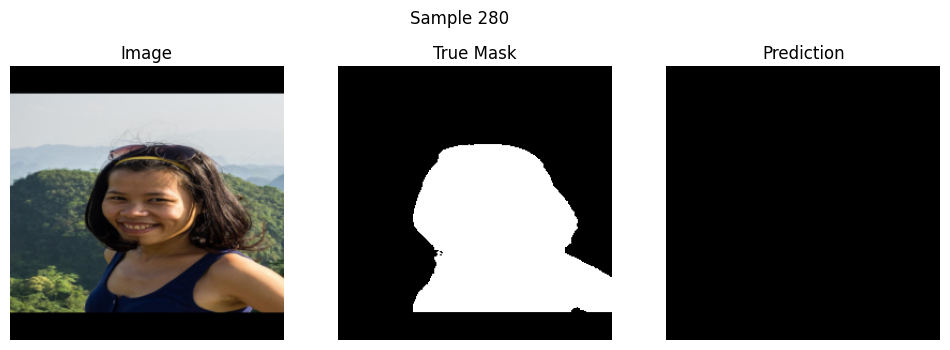

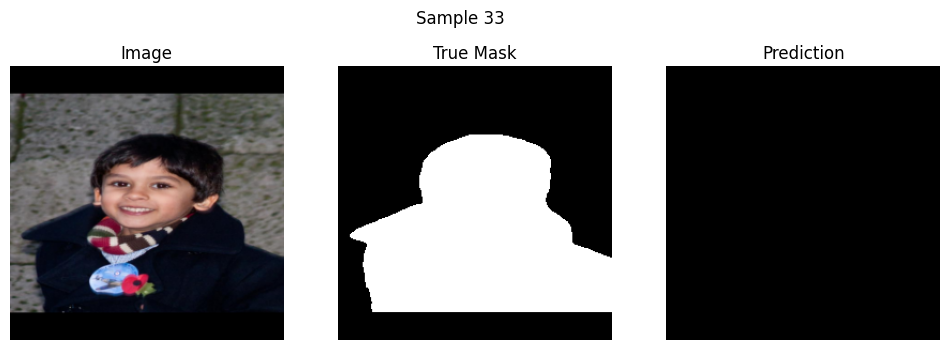

In [42]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_prediction(image, mask, prediction, index):
    image = image.permute(1, 2, 0).cpu().numpy()
    mask = mask.cpu().numpy().squeeze()
    prediction = prediction.sigmoid().cpu().numpy().squeeze() > 0.5

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('True Mask')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(prediction, cmap='gray')
    plt.title('Prediction')
    plt.axis('off')

    plt.suptitle(f'Sample {index}')
    plt.show()

# Визуализация случайных примеров
indices = np.random.choice(len(test_dataset), 3, replace=False)
for i in indices:
    visualize_prediction(test_dataset[i]['image'], all_masks[i], all_preds[i], i)
